In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stat
import h5py
import corner
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import utilities
import os
import emcee
import seaborn as sns
import warnings
import time
import pickle
from model import *
from matplotlib.patches import Patch

warnings.filterwarnings("ignore")
os.environ["OMP_NUM_THREADS"] = "1"

sns.set_style('whitegrid')
sns.set_context("paper", rc={"font.size": 12, "axes.titlesize": 12, "axes.labelsize": 12})

In [12]:
def get_model_params(modelpath):
    
    with open(modelpath, "rb") as pfile:
        model = pickle.load(pfile)
    
    # Extract params
    mu_ts = model.samples['mu_t']
    sig_ts = model.samples['sig_t']
    mu_ps = model.samples['mu_p']
    sig_ps = model.samples['sig_p']
    rhos = model.samples['rho']
    norms = model.samples['norm']

    # Initialise dict to store params
    params = {}

    # Get median values (parameters used by the model) and their error
    params['mut'] = model.mean_params['mu_t']
    params['mut_err'] = np.std(mu_ts)
    params['mup'] = model.mean_params['mu_p']
    params['mup_err'] = np.std(mu_ps)
    params['sigt'] = model.mean_params['sig_t']
    params['sigt_err'] = np.std(sig_ts)
    params['sigp'] = model.mean_params['sig_p']
    params['sigp_err'] = np.std(sig_ps)
    params['rho'] = model.mean_params['rho']
    params['rho_err'] = np.std(rhos)
    params['norm'] = model.mean_params['norm']
    params['norm_err'] = np.std(norms)

    return params

In [13]:
sol_params = get_model_params('../cultivar_models/Solstice_Yield_model.pck')
sky_params = get_model_params('../cultivar_models/Skyfall_Yield_model.pck')
claire_params = get_model_params('../cultivar_models/Claire_Yield_model.pck')
cordiale_params = get_model_params('../cultivar_models/Cordiale_Yield_model.pck')

In [14]:
muts = [sol_params['mut'], sky_params['mut'], claire_params['mut'], cordiale_params['mut']]
sigts = [sol_params['sigt'], sky_params['sigt'], claire_params['sigt'], cordiale_params['sigt']]
mups = [sol_params['mup'], sky_params['mup'], claire_params['mup'], cordiale_params['mup']]
sigps = [sol_params['sigp'], sky_params['sigp'], claire_params['sigp'], cordiale_params['sigp']]
rhos = [sol_params['rho'], sky_params['rho'], claire_params['rho'], cordiale_params['rho']]
norms = [sol_params['norm'], sky_params['norm'], claire_params['norm'], cordiale_params['norm']]
muts_err = [sol_params['mut_err'], sky_params['mut_err'], claire_params['mut_err'], cordiale_params['mut_err']]
sigts_err = [sol_params['sigt_err'], sky_params['sigt_err'], claire_params['sigt_err'], cordiale_params['sigt_err']]
mups_err = [sol_params['mup_err'], sky_params['mup_err'], claire_params['mup_err'], cordiale_params['mup_err']]
sigps_err = [sol_params['sigp_err'], sky_params['sigp_err'], claire_params['sigp_err'], cordiale_params['sigp_err']]
rhos_err = [sol_params['rho_err'], sky_params['rho_err'], claire_params['rho_err'], cordiale_params['rho_err']]
norms_err = [sol_params['norm_err'], sky_params['norm_err'], claire_params['norm_err'], cordiale_params['norm_err']]

params = np.array([muts, sigts, mups, sigps, rhos, norms])
params_err = np.array([muts_err, sigts_err, mups_err, sigps_err, rhos_err, norms_err])

In [15]:
mean_muts = np.mean(muts)
mean_sigts = np.mean(sigts)
mean_mups = np.mean(mups)
mean_sigps = np.mean(sigps)
mean_rhos = np.mean(rhos)
mean_norms = np.mean(norms)
mean_muts_err = np.std(muts) / 2
mean_sigts_err = np.std(sigts) / 2
mean_mups_err = np.std(mups) / 2
mean_sigps_err = np.std(sigps) / 2
mean_rhos_err = np.std(rhos) / 2
mean_norms_err = np.std(norms) / 2

mean_params = np.array([mean_muts, mean_sigts, mean_mups, mean_sigps, mean_rhos, mean_norms])
mean_params_err = np.array([mean_muts_err, mean_sigts_err, mean_mups_err, mean_sigps_err, mean_rhos_err, 
                            mean_norms_err])

ys = np.zeros((6, 4))
for i in range(6):
    ys[i, :] = params[i, :] / mean_params[i]

def error_prop(x, xmean, xerr, meanerr):
    return np.sqrt((1/xmean*xerr)**2 + (x/xmean**2*meanerr)**2)

errors = np.zeros((6, 4))
for i in range(6):
    errors[i, :] = error_prop(params[i, :], mean_params[i], params_err[i, :], mean_params_err[i])

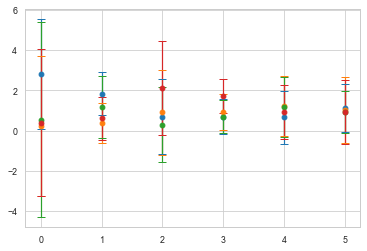

In [16]:
plt.figure()
for i, label in zip(range(4), ['Solstice', 'Skyfall', 'Claire', 'Cordiale']):
    plt.errorbar(np.arange(6), ys[:, i], yerr=errors[:, i], label=label, linestyle='none', marker='o', capsize=4)

<ErrorbarContainer object of 3 artists>

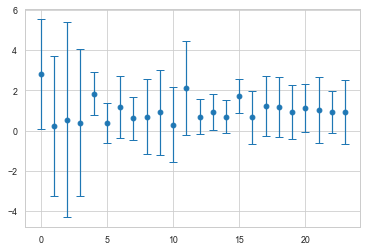

In [17]:
plt.errorbar(np.arange(6*4), ys.flatten(), yerr=errors.flatten(), label=label, linestyle='none', marker='o', capsize=4)

In [40]:
with open('../cultivar_models/Claire_Yield_model.pck', "rb") as pfile:
    claire = pickle.load(pfile)
with open('../cultivar_models/Einstein_Yield_model.pck', "rb") as pfile:
    cordaile = pickle.load(pfile)
with open('../cultivar_models/Solstice_Yield_model.pck', "rb") as pfile:
    solstice = pickle.load(pfile)
with open('../cultivar_models/Skyfall_Yield_model.pck', "rb") as pfile:
    skyfall = pickle.load(pfile)

In [30]:
def country_grid(self, yr=2010):

        # Open file
        hdf = h5py.File('../SimFarm2030.hdf5',
                        'r+')

        lat = hdf['Latitude_grid'][...]

        allmonths = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

        pred_map = np.zeros((lat.shape[0], lat.shape[1]))

        # Loop over years for each region
        temps = np.zeros((lat.shape[0], lat.shape[1], 12))
        rains = np.zeros((lat.shape[0], lat.shape[1], 12))
        year = str(yr)
        # Initialise arrays to hold results
        for mthind, month in enumerate(allmonths):
            key = str(yr) + '.' + str(month)
            temps[:, :, mthind] = hdf[key]['Monthly_mean_temperature_grid'][...]
            rains[:, :, mthind] = hdf[key]['Monthly_mean_rainfall_grid'][...]

        preds = self.gauss2d_country(self.mean_params['norm'], temps, self.mean_params['mu_t'],
                                        self.mean_params['sig_t'], rains, self.mean_params['mu_p'],
                                        self.mean_params['sig_p'], self.mean_params['rho'],
                                        dy=np.zeros_like(lat))
        pred_map = preds

        hdf.close()
        
        return pred_map

In [31]:
# Get country yield maps
claire_map = country_grid(claire, yr=2014)
cordaile_map = country_grid(cordaile, yr=2014)
solstice_map = country_grid(solstice, yr=2014)
skyfall_map = country_grid(skyfall, yr=2014)

# Initialise maps
claire_map_plt = np.full_like(claire_map, np.nan)
cordaile_map_plt = np.full_like(claire_map, np.nan)
solstice_map_plt = np.full_like(claire_map, np.nan)
skyfall_map_plt = np.full_like(claire_map, np.nan)

# Get country yield maps
claire_map_plt[claire_map != 0.0] = claire_map[claire_map != 0.0]
cordaile_map_plt[cordaile_map != 0.0] = cordaile_map[cordaile_map != 0.0]
solstice_map_plt[solstice_map != 0.0] = solstice_map[solstice_map != 0.0]
skyfall_map_plt[skyfall_map != 0.0] = skyfall_map[skyfall_map != 0.0]

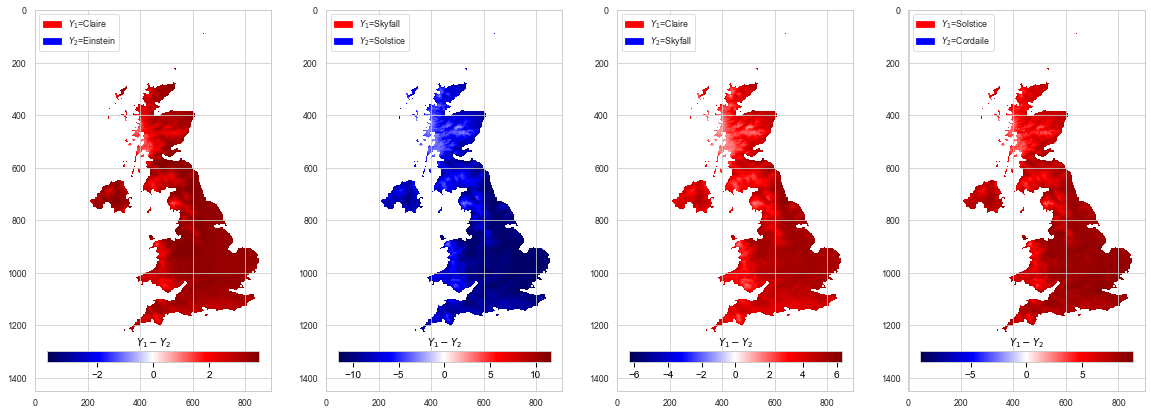

In [32]:
fig = plt.figure(figsize=(20,7))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

# Calculate residual maps
cl_co = np.flip(claire_map_plt - cordaile_map_plt, axis=0)
sk_so = np.flip(skyfall_map_plt - solstice_map_plt, axis=0)
cl_sk = np.flip(claire_map_plt - skyfall_map_plt, axis=0)
so_co = np.flip(solstice_map_plt - cordaile_map_plt, axis=0)

cl_comapmax = np.max([np.max(cl_co[~np.isnan(cl_co)]), np.abs(np.min(cl_co[~np.isnan(cl_co)]))])
sk_somapmax = np.max([np.max(sk_so[~np.isnan(sk_so)]), np.abs(np.min(sk_so[~np.isnan(sk_so)]))])
cl_skmapmax = np.max([np.max(cl_sk[~np.isnan(cl_sk)]), np.abs(np.min(cl_sk[~np.isnan(cl_sk)]))])
so_comapmax = np.max([np.max(so_co[~np.isnan(so_co)]), np.abs(np.min(so_co[~np.isnan(so_co)]))])

im1 = ax1.imshow(cl_co, cmap='seismic', vmin=-cl_comapmax, vmax=cl_comapmax)
im2 = ax2.imshow(sk_so, cmap='seismic', vmin=-sk_somapmax, vmax=sk_somapmax)
im3 = ax3.imshow(cl_sk, cmap='seismic', vmin=-cl_skmapmax, vmax=cl_skmapmax)
im4 = ax4.imshow(so_co, cmap='seismic', vmin=-so_comapmax, vmax=so_comapmax)

legend_elements1 = [Patch(facecolor='red', edgecolor='r', label='$Y_{1}$=Claire'),
                    Patch(facecolor='blue', edgecolor='b', label='$Y_{2}$=Einstein')]
legend_elements2 = [Patch(facecolor='red', edgecolor='r', label='$Y_{1}$=Skyfall'),
                    Patch(facecolor='blue', edgecolor='b', label='$Y_{2}$=Solstice')]
legend_elements3 = [Patch(facecolor='red', edgecolor='r', label='$Y_{1}$=Claire'),
                    Patch(facecolor='blue', edgecolor='b', label='$Y_{2}$=Skyfall')]
legend_elements4 = [Patch(facecolor='red', edgecolor='r', label='$Y_{1}$=Solstice'),
                    Patch(facecolor='blue', edgecolor='b', label='$Y_{2}$=Cordaile')]

ax1.legend(handles=legend_elements1, loc="upper left")
ax2.legend(handles=legend_elements2, loc="upper left")
ax3.legend(handles=legend_elements3, loc="upper left")
ax4.legend(handles=legend_elements4, loc="upper left")

# Add colorbars
cax1 = ax1.inset_axes([0.05, 0.075, 0.9, 0.03])
cax2 = ax2.inset_axes([0.05, 0.075, 0.9, 0.03])
cax3 = ax3.inset_axes([0.05, 0.075, 0.9, 0.03])
cax4 = ax4.inset_axes([0.05, 0.075, 0.9, 0.03])
cbar1 = fig.colorbar(im1, cax=cax1, orientation="horizontal")
cbar2 = fig.colorbar(im2, cax=cax2, orientation="horizontal")
cbar3 = fig.colorbar(im3, cax=cax3, orientation="horizontal")
cbar4 = fig.colorbar(im4, cax=cax4, orientation="horizontal")

# Label colorbars
cbar1.ax.set_xlabel(r'$Y_{1}-Y_{2}$', fontsize=10, color='k', labelpad=5)
cbar1.ax.xaxis.set_label_position('top')
cbar1.ax.tick_params(axis='x', labelsize=10, color='k', labelcolor='k')

cbar2.ax.set_xlabel(r'$Y_{1}-Y_{2}$', fontsize=10, color='k', labelpad=5)
cbar2.ax.xaxis.set_label_position('top')
cbar2.ax.tick_params(axis='x', labelsize=10, color='k', labelcolor='k')

cbar3.ax.set_xlabel(r'$Y_{1}-Y_{2}$', fontsize=10, color='k', labelpad=5)
cbar3.ax.xaxis.set_label_position('top')
cbar3.ax.tick_params(axis='x', labelsize=10, color='k', labelcolor='k')

cbar4.ax.set_xlabel(r'$Y_{1}-Y_{2}$', fontsize=10, color='k', labelpad=5)
cbar4.ax.xaxis.set_label_position('top')
cbar4.ax.tick_params(axis='x', labelsize=10, color='k', labelcolor='k')

fig.savefig("model_comparison_maps.png", bbox_inches='tight')

(4, 1450, 900)
[1 4]


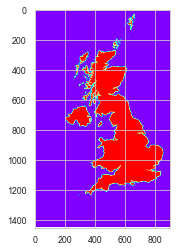

In [33]:
cols = np.array([1, 2, 3, 4])
combo = np.array([claire_map, cordaile_map, skyfall_map, solstice_map])
print(combo.shape)
all_map = cols[np.argmax(combo, axis=0)]
print(np.unique(all_map))     
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(np.flip(all_map, axis=0), cmap='rainbow')

In [44]:
skyfall.country_predict(2017, tmod=0, pmod=0, mutmod=0, mupmod=0, cultivar="Skyfall")

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<Figure size 432x288 with 0 Axes>

In [52]:
models = os.listdir("../cultivar_models/")
print(models)


def gauss2d_resp(t, norm, mu_t, sig_t, p, mu_p, sig_p, rho):

    t_term = ((t - mu_t) / sig_t) ** 2
    p_term = ((p - mu_p) / sig_p) ** 2
    tp_term = 2 * rho * (t - mu_t) * (p - mu_p) / (sig_t * sig_p)

    dy = norm * np.exp(-(1 / (2 - 2 * rho * rho)) * (t_term + p_term - tp_term))

    return dy


def plot_response(model):

    # Create arrays to evaluate response function at
    eval_t = np.linspace(0, 6000, 1000)
    eval_p = np.linspace(0, 3500, 1000)

    # Get grid of values
    tt, pp = np.meshgrid(eval_t, eval_p)

    # Compute the response grid
    resp_grid = gauss2d_resp(tt, model.mean_params["norm"], model.mean_params['mu_t'],
                             model.mean_params['sig_t'], pp, model.mean_params['mu_p'],
                             model.mean_params['sig_p'], model.mean_params['rho'])

    return eval_t, eval_p, resp_grid

['Skyfall_Yield_model.pck', 'Cordiale_Yield_model.pck', 'Alchemy_Yield_model.pck', 'Gallant_Yield_model.pck', 'Robigus_Yield_model.pck', 'JB Diego_Yield_model.pck', 'Gladiator_Yield_model.pck', 'Claire_Yield_model.pck', 'Einstein_Yield_model.pck', 'Solstice_Yield_model.pck']


In [63]:
def comp_resp(paths):
    
    # Set up figure
    fig = plt.figure(figsize=(9, 9))
    ax1 = fig.add_subplot(111)
    
    cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 
             'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 
             'PuBuGn', 'BuGn', 'YlGn']
    
    for path, cmap in zip(paths, cmaps[:len(paths)]):
        with open('../cultivar_models/' + path, "rb") as pfile:
            model = pickle.load(pfile)
            
        print(model.cult)

        mean_params = model.mean_params
        
        eval_t, eval_p, resp_grid = plot_response(model)

        # Plot the response functions
        cba = ax1.contourf(eval_t, eval_p, resp_grid, 
                           levels=[6, 8, 10, 11, 12, 13, 14], 
                           alpha=0.1, cmap=cmap, label=model.cult)
        cba = ax1.contour(eval_t, eval_p, resp_grid, 
                           levels=[6, 8, 10, 11, 12, 13, 14], cmap=cmap, label=model.cult)

    # Label axes
    ax1.set_xlabel(r"Thermal days ($^\circ$C days)")
    ax1.set_ylabel(r"$\sum P$ (mm)")
    
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels)


    # Save the figure
    fig.savefig('../Response_functions/response_comparison.png', bbox_inches='tight')

Skyfall
Cordiale
Alchemy
Gallant
Robigus
JB Diego
Gladiator
Claire
Einstein
Solstice


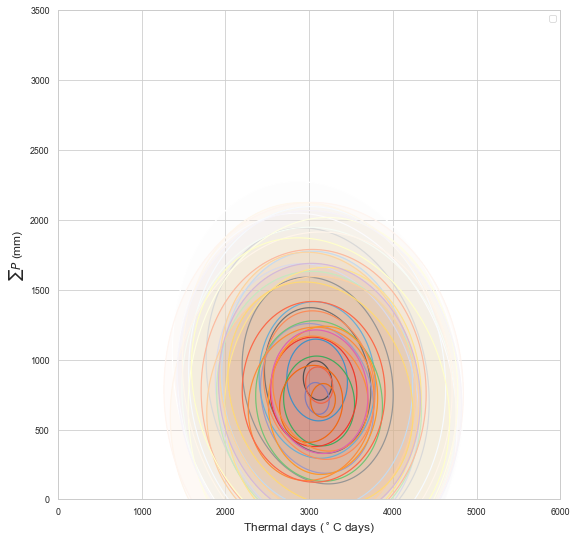

In [64]:
comp_resp(models)

In [70]:
(2520*2)**3 / 2520**3

8.0

In [35]:
models = os.listdir("../cultivar_models/")
print(models)


def comp_extremes(paths):
    
    ts = []
    ps = []
    ss = []
    preds = []
    
    for path in paths:
        if path.split("_")[-1] != "3d.pck":
            continue
        with open('../cultivar_models/' + path, "rb") as pfile:
            model = pickle.load(pfile)
            
        print(model.cult)
        
        ts.extend(model.predict_temp)
        ps.extend(model.predict_rain)
        ss.extend(model.predict_sun)
        preds.extend(model.resi)
        
        # Set up figure
        fig1 = plt.figure(figsize=(18, 5))
        ax1 = fig1.add_subplot(131)
        ax2 = fig1.add_subplot(132)
        ax3 = fig1.add_subplot(133)
        
        cult_max = np.max(np.abs(model.resi))

        im = ax1.scatter(model.predict_temp, model.predict_rain, c=model.resi, cmap='coolwarm', marker="+", vmin=-cult_max, vmax=cult_max)
        ax2.scatter(model.predict_temp, model.predict_sun, c=model.resi, cmap='coolwarm', marker="+", vmin=-cult_max, vmax=cult_max)
        ax3.scatter(model.predict_rain, model.predict_sun, c=model.resi, cmap='coolwarm', marker="+", vmin=-cult_max, vmax=cult_max)

        # Label axes
        ax1.set_xlabel(r"Thermal days ($^\circ$C days)")
        ax1.set_ylabel(r"$\sum P$ (mm)")
        ax2.set_xlabel(r"Thermal days ($^\circ$C days)")
        ax2.set_ylabel(r"$\sum S$ (hrs)")
        ax3.set_xlabel(r"$\sum P$ (mm)")
        ax3.set_ylabel(r"$\sum S$ (hrs)")

        cbar = fig1.colorbar(im)

        cbar.set_label("$1 - Y_{\mathrm{Pred}} / Y_{\mathrm{True}}$ (%)")

        # Save the figure
        fig1.savefig('../Cultivar_comparisons/extreme_climate_probe_' + model.cult + '.png', bbox_inches='tight')
        
        plt.close(fig1)
    
    print(len(preds))
    
    # Set up figure
    fig = plt.figure(figsize=(18, 5))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    
    cult_max = np.max(np.abs(preds))

    im = ax1.scatter(ts, ps, c=preds, cmap='coolwarm', marker="+", vmin=-cult_max, vmax=cult_max)
    ax2.scatter(ts, ss, c=preds, cmap='coolwarm', marker="+", vmin=-cult_max, vmax=cult_max)
    ax3.scatter(ps, ss, c=preds, cmap='coolwarm', marker="+", vmin=-cult_max, vmax=cult_max)

    # Label axes
    ax1.set_xlabel(r"Thermal days ($^\circ$C days)")
    ax1.set_ylabel(r"$\sum P$ (mm)")
    ax2.set_xlabel(r"Thermal days ($^\circ$C days)")
    ax2.set_ylabel(r"$\sum S$ (hrs)")
    ax3.set_xlabel(r"$\sum P$ (mm)")
    ax3.set_ylabel(r"$\sum S$ (hrs)")

    cbar = fig.colorbar(im)

    cbar.set_label("$1 - Y_{\mathrm{Pred}} / Y_{\mathrm{True}}$ (%)")

    # Save the figure
    fig.savefig('../Cultivar_comparisons/extreme_climate_probe.png', bbox_inches='tight')

['Solstice_Yield_model_daily.pck', 'Skyfall_Yield_model.pck', 'Cordiale_Yield_model.pck', 'Robigus_Yield_model_daily.pck', 'Alchemy_Yield_model.pck', 'Gallant_Yield_model_daily.pck', 'Einstein_Yield_model_daily_3d.pck', 'Claire_Yield_model_daily_3d.pck', 'Claire_Yield_model_daily.pck', 'Gallant_Yield_model.pck', 'Skyfall_Yield_model_daily_3d.pck', 'Solstice_Yield_model_daily_3d.pck', 'Skyfall_Yield_model_daily.pck', 'Einstein_Yield_model_daily.pck', 'Alchemy_Yield_model_daily.pck', 'Cordiale_Yield_model_daily_3d.pck', 'Gladiator_Yield_model_daily.pck', 'Robigus_Yield_model.pck', 'Gladiator_Yield_model_daily_3d.pck', 'JB Diego_Yield_model.pck', 'JB Diego_Yield_model_daily_3d.pck', 'Robigus_Yield_model_daily_3d.pck', 'JB Diego_Yield_model_daily.pck', 'Gladiator_Yield_model.pck', 'Alchemy_Yield_model_daily_3d.pck', 'Claire_Yield_model.pck', 'Gallant_Yield_model_daily_3d.pck', 'Einstein_Yield_model.pck', 'Cordiale_Yield_model_daily.pck', 'Solstice_Yield_model.pck']


Einstein
Claire
Skyfall
Solstice
Cordiale
Gladiator
JB Diego
Robigus
Alchemy
Gallant
636


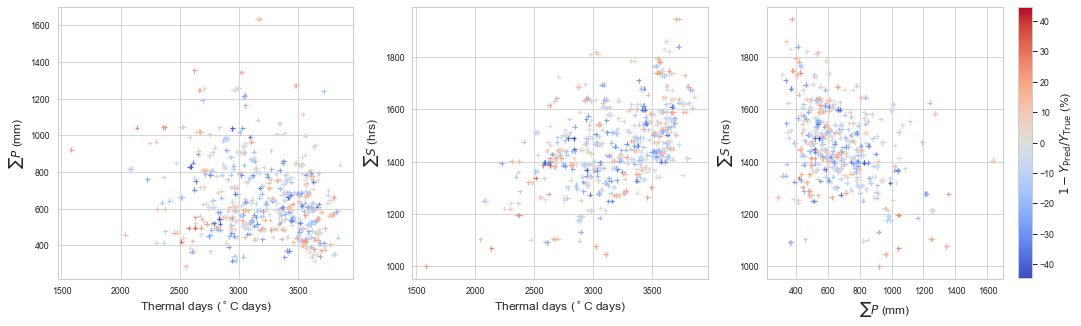

In [36]:
comp_extremes(models)

In [37]:
def comp_extremes_scatter(paths):
    
    ts = []
    ps = []
    ss = []
    preds = []
    
    for path in paths:
        if path.split("_")[-1] != "3d.pck":
            continue
        with open('../cultivar_models/' + path, "rb") as pfile:
            model = pickle.load(pfile)
            
        print(model.cult)
        
        ts.extend(model.predict_temp)
        ps.extend(model.predict_rain)
        ss.extend(model.predict_sun)
        preds.extend(model.resi)
        
        # Set up figure
        fig1 = plt.figure(figsize=(18, 5))
        ax1 = fig1.add_subplot(131)
        ax2 = fig1.add_subplot(132)
        ax3 = fig1.add_subplot(133)
        
        cult_max = np.max(np.abs(model.resi))

        im = ax1.scatter(model.predict_temp, model.resi, marker="+")
        ax2.scatter(model.predict_rain, model.resi, marker="+")
        ax3.scatter(model.predict_sun, model.resi, marker="+")

        # Label axes
        ax1.set_xlabel(r"Thermal days ($^\circ$C days)")
        ax1.set_ylabel("$1 - Y_{\mathrm{Pred}} / Y_{\mathrm{True}}$ (%)")
        ax2.set_xlabel(r"$\sum P$ (mm)")
        ax2.set_ylabel("$1 - Y_{\mathrm{Pred}} / Y_{\mathrm{True}}$ (%)")
        ax3.set_xlabel(r"$\sum S$ (mm)")
        ax3.set_ylabel("$1 - Y_{\mathrm{Pred}} / Y_{\mathrm{True}}$ (%)")

        # Save the figure
        fig1.savefig('../Cultivar_comparisons/extreme_climate_probe_scatter' + model.cult + '.png', bbox_inches='tight')
        
        plt.close(fig1)
    
    print(len(preds))
    
    # Set up figure
    fig = plt.figure(figsize=(18, 5))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    
    cult_max = np.max(np.abs(preds))

    im = ax1.scatter(ts, preds, marker="+")
    ax2.scatter(ps, preds, marker="+")
    ax3.scatter(ss, preds, marker="+")

    # Label axes
    ax1.set_xlabel(r"Thermal days ($^\circ$C days)")
    ax1.set_ylabel("$1 - Y_{\mathrm{Pred}} / Y_{\mathrm{True}}$ (%)")
    ax2.set_xlabel(r"$\sum P$ (mm)")
    ax2.set_ylabel("$1 - Y_{\mathrm{Pred}} / Y_{\mathrm{True}}$ (%)")
    ax3.set_xlabel(r"$\sum S$ (mm)")
    ax3.set_ylabel("$1 - Y_{\mathrm{Pred}} / Y_{\mathrm{True}}$ (%)")

    # Save the figure
    fig.savefig('../Cultivar_comparisons/extreme_climate_probe_scatter.png', bbox_inches='tight')

Einstein
Claire
Skyfall
Solstice
Cordiale
Gladiator
JB Diego
Robigus
Alchemy
Gallant
636


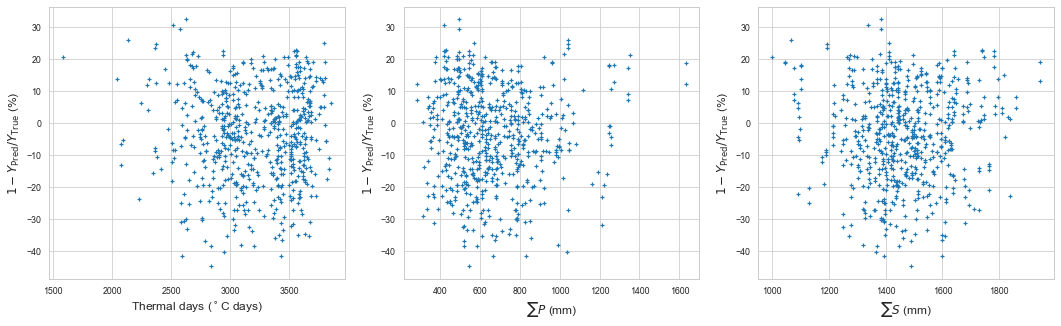

In [38]:
comp_extremes_scatter(models)

['Solstice_Yield_model_daily.pck', 'Skyfall_Yield_model.pck', 'Cordiale_Yield_model.pck', 'Robigus_Yield_model_daily.pck', 'Alchemy_Yield_model.pck', 'Gallant_Yield_model_daily.pck', 'Einstein_Yield_model_daily_3d.pck', 'Claire_Yield_model_daily_3d.pck', 'Claire_Yield_model_daily.pck', 'Gallant_Yield_model.pck', 'Skyfall_Yield_model_daily_3d.pck', 'Solstice_Yield_model_daily_3d.pck', 'Skyfall_Yield_model_daily.pck', 'Einstein_Yield_model_daily.pck', 'Alchemy_Yield_model_daily.pck', 'Cordiale_Yield_model_daily_3d.pck', 'Gladiator_Yield_model_daily.pck', 'Robigus_Yield_model.pck', 'Gladiator_Yield_model_daily_3d.pck', 'JB Diego_Yield_model.pck', 'JB Diego_Yield_model_daily_3d.pck', 'Robigus_Yield_model_daily_3d.pck', 'JB Diego_Yield_model_daily.pck', 'Gladiator_Yield_model.pck', 'Alchemy_Yield_model_daily_3d.pck', 'Claire_Yield_model.pck', 'Gallant_Yield_model_daily_3d.pck', 'Einstein_Yield_model.pck', 'Cordiale_Yield_model_daily.pck', 'Solstice_Yield_model.pck']
Einstein
Claire
Skyfall


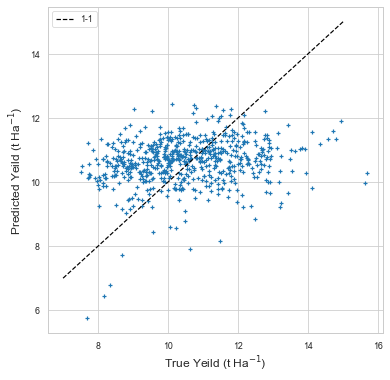

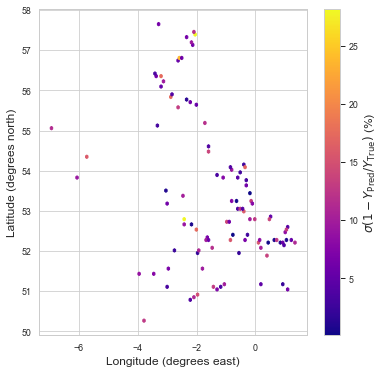

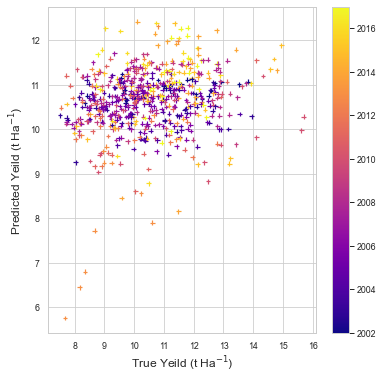

In [33]:
models = os.listdir("../cultivar_models/")
print(models)

def comp_clustering(paths):
    
    ys = []
    preds = []
    
    for path in paths:
        if path.split("_")[-1] != "3d.pck":
            continue
        with open('../cultivar_models/' + path, "rb") as pfile:
            model = pickle.load(pfile)
            
        print(model.cult)
        
        ys.extend(model.predict_yields)
        preds.extend(model.preds)
    
    print(len(preds))
    
    # Set up figure
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(111)

    im = ax1.scatter(ys, preds, marker="+")
    ax1.plot((7, 15), (7, 15), linestyle="--", color="k", label="1-1")

    # Label axes
    ax1.set_xlabel(r"True Yeild (t Ha$^{-1}$)")
    ax1.set_ylabel(r"Predicted Yeild (t Ha$^{-1}$)")
    
    ax1.legend()

    # Save the figure
    fig.savefig('../Cultivar_comparisons/prediction_clustering.png', bbox_inches='tight')
    
comp_clustering(models)

def comp_clustering_latlong(paths):
    
    preds = []
    lats = []
    longs = []
    
    for path in paths:
        if path.split("_")[-1] != "3d.pck":
            continue
        with open('../cultivar_models/' + path, "rb") as pfile:
            model = pickle.load(pfile)
            
        print(model.cult)
        
        lats.extend(model.predict_lat)
        longs.extend(model.predict_long)
        preds.extend(model.resi)
    
    print(len(preds))
    
    # Set up figure
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(111)

    im = ax1.scatter(longs, preds, marker="+")

    # Label axes
    ax1.set_xlabel(r"Longitude (degrees east)")
    ax1.set_ylabel("$1 - Y_{\mathrm{Pred}} / Y_{\mathrm{True}}$ (%)")

    # Save the figure
    fig.savefig('../Cultivar_comparisons/prediction_clustering_long.png', bbox_inches='tight')
    
    plt.close(fig)
    
    # Set up figure
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(111)

    im = ax1.scatter(lats, preds, marker="+")

    # Label axes
    ax1.set_xlabel(r"Latitude (degrees north)")
    ax1.set_ylabel("$1 - Y_{\mathrm{Pred}} / Y_{\mathrm{True}}$ (%)")

    # Save the figure
    fig.savefig('../Cultivar_comparisons/prediction_clustering_lat.png', bbox_inches='tight')
    
    plt.close(fig)
    
    lats = np.array(lats)
    longs = np.array(longs)
    
    # Set up figure
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(111)

    im = ax1.scatter(np.sqrt(lats**2 + longs**2), preds, marker="+")

    # Label axes
    ax1.set_xlabel(r"r")
    ax1.set_ylabel("$1 - Y_{\mathrm{Pred}} / Y_{\mathrm{True}}$ (%)")

    # Save the figure
    fig.savefig('../Cultivar_comparisons/prediction_clustering_r.png', bbox_inches='tight')
    
    plt.close(fig)
    
        # Set up figure
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(111)
    
    cult_max = np.max(np.abs(preds))

    im = ax1.hexbin(longs, lats, C=preds, cmap='coolwarm', gridsize=100, mincnt=1, 
                    vmin=-cult_max, vmax=cult_max, reduce_C_function=np.mean)

    # Label axes
    ax1.set_xlabel(r"Longitude (degrees east)")
    ax1.set_ylabel(r"Latitude (degrees north)")
    
    cbar = fig.colorbar(im)

    cbar.set_label("$<1 - Y_{\mathrm{Pred}} / Y_{\mathrm{True}}>$ (%)")

    # Save the figure
    fig.savefig('../Cultivar_comparisons/prediction_clustering_latlong.png', bbox_inches='tight')
    
    plt.close(fig)
    
    # Set up figure
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(111)
    
    cult_max = np.max(np.abs(preds))

    im = ax1.hexbin(longs, lats, C=preds, cmap='plasma', gridsize=100, mincnt=1, reduce_C_function=np.std)

    # Label axes
    ax1.set_xlabel(r"Longitude (degrees east)")
    ax1.set_ylabel(r"Latitude (degrees north)")
    
    cbar = fig.colorbar(im)

    cbar.set_label("$\sigma(1 - Y_{\mathrm{Pred}} / Y_{\mathrm{True}})$ (%)")

    # Save the figure
    fig.savefig('../Cultivar_comparisons/prediction_clustering_latlongstd.png', bbox_inches='tight')
    
comp_clustering_latlong(models)


def comp_clustering_year(paths):
    
    years = []
    ys = []
    preds = []
    
    for path in paths:
        if path.split("_")[-1] != "3d.pck":
            continue
        with open('../cultivar_models/' + path, "rb") as pfile:
            model = pickle.load(pfile)
            
        print(model.cult)
        
        ys.extend(model.predict_yields)
        preds.extend(model.preds)
        years.extend(model.predict_years)
    
    print(len(preds))
    
    # Set up figure
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(111)
    
    cult_max = np.max(np.abs(preds))

    im = ax1.scatter(ys, preds, c=years, cmap='plasma', marker="+")

    # Label axes
    ax1.set_xlabel(r"True Yeild (t Ha$^{-1}$)")
    ax1.set_ylabel(r"Predicted Yeild (t Ha$^{-1}$)")
    
    fig.colorbar(im)

    # Save the figure
    fig.savefig('../Cultivar_comparisons/prediction_clustering_year.png', bbox_inches='tight')
    
comp_clustering_year(models)